In [2]:
import sys
%matplotlib widget
import seaborn as sns

from msc_thesis_functions import *
del sys.modules['msc_thesis_functions']
from msc_thesis_functions import *

from scipy.stats import linregress
import seaborn as sns

import cmocean as cmo

import pyproj
import verde as vd

import h5py
import os
import numpy as np
import random
from haversine import haversine, Unit, inverse_haversine

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from cmocean import cm
from pydlc import dense_lines
import cmasher as cmr

import pandas as pd
import geopandas as gpd
import xarray as xr
from datetime import datetime, timedelta
import fiona
import cartopy
from cartopy.mpl import geoaxes
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.geodesic import Geodesic

import shapely
from shapely.geometry import Polygon, Point, MultiPoint, LineString, mapping
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection
from tqdm.notebook import trange, tqdm
from time import sleep
import rioxarray

#Variogram 
import gstools as gs

# import skgstat as skg
# from geopy.distance import vincenty
from scipy.signal import find_peaks
from scipy.spatial.distance import pdist, squareform

#Kriging (pykrige, gstoools, skg)
import pykrige.kriging_tools as kt

from pykrige.ok import OrdinaryKriging
del sys.modules['pykrige.ok']
from pykrige.ok import OrdinaryKriging

from pykrige.uk import UniversalKriging


# Building a 'Blues' colormap where the lower end (white) is transperant
ncolors = 256
color_array = plt.get_cmap('Greys')(range(ncolors))
color_array[:,-1] = np.linspace(0.0,1.0,ncolors)
map_object = LinearSegmentedColormap.from_list(name='Greys_alpha',colors=color_array)

# register this new colormap with matplotlib
# plt.colormaps.register(cmap=map_object)

from pyfonts import load_font

# font = load_font(
#    "https://github.com/google/fonts/blob/main/ofl/roboto/Roboto[wdth,wght].ttf?raw=true"
# )

from pyproj import Transformer
transformer = Transformer.from_crs(4326, 3413, always_xy=True)
import skgstat as skg

pd.options.mode.chained_assignment = None  # default='warn'


In [3]:
def get_extent_xy(x,y):
    return (min(x), min(y), max(x), max(y))

def measurement_bounds_with_dist(dist, x, y):
    """
    Using a distance (e.g. from a predetermined variogram model (with length scale)) to construct a polygon that represents the area 
    within the extent (from min and max of x and y) where the point-measurements are within the given distance (e.g. being still auto-correlated).    
     
    Args:
        dist (float): Buffer distance around points
        x (float): Locations in x-direction [m]
        y (float):  Location in y-direction [m]
    
    Returns:
        A shapely.Polygon that outlines the measurement boundaries.
    """
    
    circles = [Point(xi,yi).buffer(dist) for xi, yi in list(zip(x, y))]
    union = shapely.union_all(circles)

    # try: 
    #     areas = []
    #     for shp in union.geoms:
    #         areas.append(shp.area)

    #     maxind = np.argmax(areas)
    #     union = union.geoms[maxind]
    # except:
    #     pass

    intersec = Polygon.intersection(union,  Polygon.from_bounds(*get_extent_xy(x, y)))
    return intersec

def plot_polygon(ax, poly, **kwargs):
    path = Path.make_compound_path(
        Path(np.asarray(poly.exterior.coords)[:, :2]),
        *[Path(np.asarray(ring.coords)[:, :2]) for ring in poly.interiors])

    patch = PathPatch(path, **kwargs)
    collection = PatchCollection([patch], **kwargs)
    
    ax.add_collection(collection, autolim=True)
    ax.autoscale_view()
    return collection


In [4]:

####### Setup #######
extent = (272, 79.723705,274, 80.576499) #minlon, minlat, maxlon, maxlat for EUREKA 2014 (and 2016?)

year = '2014'

campaigns = [
    # 'CRYOVEX2014',
    'EUREKA2014',
    # 'EUREKA2016',
]

paths_MP = [
    # '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/CryoVEx2014_SEAICE_GROUNDDATA_V1/NORD_CAMP_TRANSECT.csv', #CRYOVEX 2014
    '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/ECCCEureka2014.h5', #EUREKA 2014
    # '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/ECCC_2016_Eureka_Magnaprobe.csv' #EUREKA 2016
]

output_path = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/krigging3'

In [5]:
# load magnaprobe in situ data
path_MP = paths_MP[0]

filetype = path_MP.split('.')[1]
df_dict = open_data(path_MP, filetype=filetype, mode='dict', instrument='MP')

if year == '2014':
    f = h5py.File(path_MP, 'r')
    group = f['eureka_data']
    data = group['magnaprobe']
    df_df = pd.DataFrame({'lat':data['latitude'][()], 'lon':data['longitude'][()], 'snow_depth':data['snow_depth'][()], 'site_id':data['site_id'][()]})
    df_df.loc[df_df['lon'] < 0, 'lon'] += 360
    df_df['ice_type'] = ['fyi']*len(df_df)
    
elif year == '2016':
    for key in df_dict.keys():
        if key == list(df_dict.keys())[0]:
            df_df = df_dict[key]
        else:
            df_df = pd.concat([df_df, df_dict[key]])
            
df_df['x'], df_df['y'] = transformer.transform(df_df['lon'], df_df['lat'])

sites = df_df['site_id'].unique()

In [6]:
# stepsize = 1 
# instrument_error = 0.007 # MagnaProbe instrument error: 7 mm
exact_values = True
kriging = True
length_scale = 'effective' #could alse be "effective"
print(f'Do kriging: {kriging}')
print(f'Exact kriging: {exact_values}')
print(f'Kriging length scale: {length_scale}')

dist = 50 if year == '2014' else 10

write_measurement_bounds = False
shape_path = f'/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/grid_extents_v4'

output_path = f'/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/krigging_onATMgrid_v5_exact{str(exact_values)}'
topography_grid_path = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/OIB/ATM_gridded/gridding_v7'
plotting_path = f'/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Plots/Finalized plots/kriging_validation'
output_path #'/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Plots/20241213/automated_kriging_plots2'

# site = 'grid3'

for site in tqdm(sites[3:]): #sites
    print(site)
    
    df_f = df_df.loc[df_df['site_id'] == site]
    df_f.reset_index(inplace=True, drop=True)
    
    nr_val_points = int(len(df_f) / 10)
    val_indices = np.sort(random.sample(range(1, len(df_f)), nr_val_points))

    validation_subset = df_f.loc[val_indices]
    validation_subset.reset_index(inplace=True, drop=True)
    
    df_f = df_f.drop(val_indices)

    grid = xr.open_dataset(os.path.join(topography_grid_path,f'{campaigns[0]}_ATM_gridded_{site}.nc'))
    
    # Step 1: Find the nearest grid indices
    # Convert xarray coordinates to NumPy arrays
    grid_x = grid["easting"].values
    grid_y = grid["northing"].values

    # Find the closest index for each point
    df_f["x_idx"] = np.searchsorted(grid_x, df_f["x"]) - 1
    df_f["y_idx"] = np.searchsorted(grid_y, df_f["y"]) - 1

    # Ensure indices are within bounds
    df_f["x_idx"] = df_f["x_idx"].clip(0, len(grid_x) - 1)
    df_f["y_idx"] = df_f["y_idx"].clip(0, len(grid_y) - 1)

    # Step 2: Retrieve the classification value from the grid
    classification = grid["classes"].values
    df_f["classes"] = classification[df_f["y_idx"], df_f["x_idx"]]
    
    # seperate dataframe into undeformed/ deformed
    df_f_undeformed = df_f.loc[df_f['classes'] == 0]
    df_f_deformed = df_f.loc[df_f['classes'] == 1]

    # construct grids for later use
    grid_x, grid_y = grid['easting'].values, grid['northing'].values
    grid_xx, grid_yy = np.meshgrid(grid_x, grid_y, indexing='xy')
    grid_x, grid_y = grid_xx.flatten(), grid_yy.flatten()

    grid_inds = np.arange(len(grid_x))
    
    elevs = grid['elevation'].values.flatten()
    mask = ~np.isnan(elevs)
    
    #construct masked grid axis and indices
    grid_x_masked, grid_y_masked = grid_x[mask], grid_y[mask]
    grid_inds_masked = grid_inds[mask]
    
    
    # mask furhter into deformed/ undeformed based on classes
    classes = grid['classes'].values.flatten()
    classes = classes[mask]

    grid_undeformed_x = grid_x_masked[classes == 0]
    grid_undeformed_y = grid_y_masked[classes == 0]

    grid_deformed_x = grid_x_masked[classes == 1]
    grid_deformed_y = grid_y_masked[classes == 1]

    grid_inds_undeformed  = grid_inds_masked[classes == 0]
    grid_inds_deformed  = grid_inds_masked[classes == 1]


    #calculate mean seperation distance between consecutive data points
    dists = cdist(np.column_stack([df_f['x'], df_f['y']]), np.column_stack([df_f['x'], df_f['y']]))
    dists[dists==0] = np.nan
    mean_distance = np.nanmean(dists[np.arange(1, len(df_f_undeformed)), np.arange(len(df_f_undeformed) - 1)])

    
    # construct bins for variogram estimation 
    dists = cdist(np.column_stack([df_f_undeformed['x'], df_f_undeformed['y']]), np.column_stack([df_f_undeformed['x'], df_f_undeformed['y']]))
    dists[dists==0] = np.nan
    bins_undeformed = np.arange(np.nanmin(dists), np.nanquantile(dists,.15), mean_distance)
    
    dists = cdist(np.column_stack([df_f_deformed['x'], df_f_deformed['y']]), np.column_stack([df_f_deformed['x'], df_f_deformed['y']]))
    dists[dists==0] = np.nan
    bins_deformed = np.arange(np.nanmin(dists), np.nanquantile(dists,.15), mean_distance/2)
    
    
    # calculate variograms
    flag = 'both'
    
    try:
        bin_center_undeformed, vario_undeformed, counts_undeformed = gs.vario_estimate((df_f_undeformed['y'], df_f_undeformed['x']), df_f_undeformed['snow_depth'],
                                        return_counts=True,
                                        bin_edges=bins_undeformed
                                        )
        model_undeformed = gs.Matern()
        _,_,r2_undeformed = model_undeformed.fit_variogram(bin_center_undeformed, vario_undeformed,
                                    init_guess={"len_scale": 10},
                                    return_r2=True
                                    )
        # variogram_plot(bin_center_undeformed, vario_undeformed, counts_undeformed, model_undeformed, r2_undeformed, save_path=os.path.join(plotting_path, f'{campaigns[0]}_{site}_variogram_undeformed.png'))
        print(f'R2, undeformed: {r2_undeformed:.2f}')
        if r2_undeformed < .7:
            flag = 'fully_deformed'
    except:
        flag = 'fully_deformed'


    try:
        bin_center_deformed, vario_deformed, counts_deformed = gs.vario_estimate((df_f_deformed['y'], df_f_deformed['x']), df_f_deformed['snow_depth'],
                                            return_counts=True,
                                            bin_edges=bins_deformed
                                            )
        model_deformed = gs.Matern()
        _,_, r2_deformed = model_deformed.fit_variogram(bin_center_deformed, vario_deformed,
                                    init_guess={"len_scale": 10},
                                    return_r2=True
                                    )

        # variogram_plot(bin_center_deformed, vario_deformed, counts_deformed, model_deformed, r2_deformed, save_path=os.path.join(plotting_path, f'{campaigns[0]}_{site}_variogram_deformed.png'))
        print(f'R2, deformed: {r2_deformed:.2f}')     
        if r2_deformed < .7:
            flag = 'fully_undeformed'
    except:
        flag = 'fully_undeformed'
        
    print('Variograms estimated...')
    print(flag)
    
    if length_scale == 'effective':
            undeformed_length_scale = model_undeformed.len_scale
            deformed_length_scale = model_deformed.len_scale
    else:
        undeformed_length_scale = model_undeformed.percentile_scale(float(length_scale))
        deformed_length_scale = model_deformed.percentile_scale(float(length_scale))
    
    print(f'Length scales: undeformed: {undeformed_length_scale:.2f}, deformed: {deformed_length_scale:.2f}')
    if flag == 'both':
        
       
        # compute grids to perform kriging on (masking out points that are beyond the modelled variogram range)
        intersec = measurement_bounds_with_dist(dist, df_f['x'], df_f['y'])
        intersec = shapely.buffer(intersec, -dist)
        union = measurement_bounds_with_dist(min(undeformed_length_scale, deformed_length_scale), df_f['x'], df_f['y'])


        geoms_final = []
        try:
            geoms1 = [geom for geom in intersec.geoms if geom.area > 100]
        except:
            geoms1 = [intersec]
            
        try:
            geoms2 = [geom for geom in union.geoms if geom.area > 100]
        except:
            geoms2 = [union] 

        for geom1 in geoms1:
            for geom2 in geoms2:
                intersec2 = shapely.intersection(geom1, geom2)
                
                if intersec2.area > 100:
                    geoms_final.append(intersec2)
        
        if write_measurement_bounds:
            gdf = gpd.GeoDataFrame(geometry=geoms_final)
            gdf.to_file(os.path.join(shape_path, f'{campaigns[0]}_{site}_measurement_bounds.shp'))
            
        # undeformed
        points_undeformed = [Point(xi,yi) for xi, yi in list(zip(grid_undeformed_x, grid_undeformed_y))]
        di_undeformed = points_in_single_poly(geoms_final, points_undeformed)
        indices_undeformed = np.unique(np.concatenate([np.array(di_undeformed[key]) for key in di_undeformed.keys()]))
        grid_undeformed_x, grid_undeformed_y = grid_undeformed_x[indices_undeformed], grid_undeformed_y[indices_undeformed]
        grid_inds_undeformed = grid_inds_undeformed[indices_undeformed]
        
        # deformed
        points_deformed = [Point(xi,yi) for xi, yi in list(zip(grid_deformed_x, grid_deformed_y))]
        di_deformed = points_in_single_poly(geoms_final, points_deformed)
        indices_deformed = np.unique(np.concatenate([np.array(di_deformed[key]) for key in di_deformed.keys()]))
        grid_deformed_x, grid_deformed_y = grid_deformed_x[indices_deformed], grid_deformed_y[indices_deformed]
        grid_inds_deformed = grid_inds_deformed[indices_deformed]
        
        print(f'{len(grid_inds_deformed) + len(grid_inds_undeformed)} datapoints to do kriging on... ')

        if kriging == True:

            # perform kriging
            OK_undeformed = OrdinaryKriging(df_f_undeformed['x'], df_f_undeformed['y'], df_f_undeformed['snow_depth'],
                    variogram_model=gs.Matern(dim=2, len_scale=undeformed_length_scale, nugget=model_undeformed.nugget, var=model_undeformed.var),
                    exact_values=exact_values,
                    )
            z_undeformed, ss_undeformed = OK_undeformed.execute("points", grid_undeformed_x, grid_undeformed_y)

            OK_deformed = OrdinaryKriging(df_f_deformed['x'], df_f_deformed['y'], df_f_deformed['snow_depth'],
                    variogram_model=gs.Matern(dim=2, len_scale=deformed_length_scale, nugget=model_deformed.nugget, var=model_deformed.var),
                    exact_values=False
            )
            z_deformed, ss_deformed = OK_deformed.execute("points", grid_deformed_x, grid_deformed_y)
            print('Kriging done... ')
            
            # put the results onto the ATM grid
            z_gridded = np.empty_like(grid_x)
            z_gridded[:] = np.nan
            z_gridded[grid_inds_undeformed] = z_undeformed
            z_gridded[grid_inds_deformed] = z_deformed
            z_gridded = z_gridded.reshape(np.shape(grid_xx))


            ss_gridded = np.empty_like(grid_x)
            ss_gridded[:] = np.nan
            ss_gridded[grid_inds_undeformed] = ss_undeformed
            ss_gridded[grid_inds_deformed] = ss_deformed
            ss_gridded = ss_gridded.reshape(np.shape(grid_xx))
            
            grid_joint_x = np.concatenate((grid_deformed_x,grid_undeformed_x), axis=0)
            grid_joint_y = np.concatenate((grid_deformed_y,grid_undeformed_y), axis=0)
            joint_z = np.concatenate((z_deformed,z_undeformed), axis=0)

            kriging_locations = np.column_stack([grid_joint_x, grid_joint_y])
            validation_locations = np.column_stack([validation_subset['x'].to_list(), validation_subset['y'].to_list()])

            #compare kriging results to validation datapoints
            dists = cdist(validation_locations,kriging_locations)
            kriging_indices = np.argmin(dists, axis=1)
            point_distance = np.min(dists, axis=1)

            c = np.concatenate(([1]*len(grid_deformed_x),[0]*len(grid_undeformed_x)), axis=0)
        
     # if deformed does not give good results, we krig the whole field with the results from undeformed (in the final file, the classes are still given, so we can judge whether we like the fit)
    elif flag == 'fully_undeformed':
        
        intersec = measurement_bounds_with_dist(dist, df_f['x'], df_f['y'])
        
        intersec = shapely.buffer(intersec, -dist)
        union = measurement_bounds_with_dist(undeformed_length_scale, df_f['x'], df_f['y'])

        geoms_final = []
        try:
            geoms1 = [geom for geom in intersec.geoms if geom.area > 100]
        except:
            geoms1 = [intersec]
            
        try:
            geoms2 = [geom for geom in union.geoms if geom.area > 100]
        except:
            geoms2 = [union] 

        for geom1 in geoms1:
            for geom2 in geoms2:
                intersec2 = shapely.intersection(geom1, geom2)
                
                if intersec2.area > 100:
                    geoms_final.append(intersec2)
                    
        if write_measurement_bounds:
            gdf = gpd.GeoDataFrame(geometry=geoms_final)
            gdf.to_file(os.path.join(shape_path, f'{campaigns[0]}_{site}_measurement_bounds.shp'))
            
        points = [Point(xi,yi) for xi, yi in list(zip(grid_x_masked, grid_y_masked))]
        di = points_in_single_poly(geoms_final, points)
        indices = np.unique(np.concatenate([np.array(di[key]) for key in di.keys()]))
        grid_x_masked, grid_y_masked = grid_x_masked[indices], grid_y_masked[indices]
        grid_inds_masked = grid_inds_masked[indices]
        
        
        # intersec = measurement_bounds_with_dist(model_undeformed.len_scale, df_f['x'], df_f['y'])
        # points = [Point(xi,yi) for xi, yi in list(zip(grid_x_masked, grid_y_masked))]
        # indices = points_in_single_poly(intersec, points)[0]
        # grid_x_masked, grid_y_masked = grid_x_masked[indices], grid_y_masked[indices]
        # grid_inds_masked = grid_inds_masked[indices]
        
        
        print(f'{len(grid_inds_masked)} datapoints to do kriging on... ')
        
        if kriging == True:
            # perform kriging
            OK= OrdinaryKriging(df_f['x'], df_f['y'], df_f['snow_depth'],
                    variogram_model=gs.Matern(dim=2, len_scale=undeformed_length_scale, nugget=model_undeformed.nugget, var=model_undeformed.var),
                    exact_values=exact_values,
                    )
            z, ss = OK.execute("points", grid_x_masked, grid_y_masked)
            print('Kriging done... ')
            
            z_gridded = np.empty_like(grid_x)
            z_gridded[:] = np.nan
            z_gridded[grid_inds_masked] = z
            z_gridded = z_gridded.reshape(np.shape(grid_xx))


            ss_gridded = np.empty_like(grid_x)
            ss_gridded[:] = np.nan
            ss_gridded[grid_inds_masked] = ss
            ss_gridded = ss_gridded.reshape(np.shape(grid_xx))
            
            joint_z = z.copy()

            kriging_locations = np.column_stack([grid_x_masked, grid_y_masked])
            validation_locations = np.column_stack([validation_subset['x'].to_list(), validation_subset['y'].to_list()])

            #compare kriging results to validation datapoints
            dists = cdist(validation_locations,kriging_locations)
            kriging_indices = np.argmin(dists, axis=1)
            point_distance = np.min(dists, axis=1)
            
            c = np.concatenate(([1]*len(grid_undeformed_x),[0]*len(grid_undeformed_x)), axis=0)
    
    
     # if undeformed does not give good results, we krig the whole field with the results from deformed (in the final file, the classes are still given, so we can judge whether we like the fit)
    elif flag == 'fully_deformed':
        
        
        intersec = measurement_bounds_with_dist(dist, df_f['x'], df_f['y'])
        if write_measurement_bounds:
            gdf = gpd.GeoDataFrame(geometry=[intersec])
            gdf.to_file(os.path.join(shape_path, f'{campaigns[0]}_{site}_measurement_bounds.shp'))
        intersec = shapely.buffer(intersec, -dist)
        union = measurement_bounds_with_dist(deformed_length_scale, df_f['x'], df_f['y'])

        geoms_final = []
        try:
            geoms1 = [geom for geom in intersec.geoms if geom.area > 100]
        except:
            geoms1 = [intersec]
            
        try:
            geoms2 = [geom for geom in union.geoms if geom.area > 100]
        except:
            geoms2 = [union] 

        for geom1 in geoms1:
            for geom2 in geoms2:
                intersec2 = shapely.intersection(geom1, geom2)
                
                if intersec2.area > 100:
                    geoms_final.append(intersec2)
        

        if write_measurement_bounds:
            gdf = gpd.GeoDataFrame(geometry=geoms_final)
            gdf.to_file(os.path.join(shape_path, f'{campaigns[0]}_{site}_measurement_bounds.shp'))\
                
        points = [Point(xi,yi) for xi, yi in list(zip(grid_x_masked, grid_y_masked))]
        di = points_in_single_poly(geoms_final, points)
        indices = np.unique(np.concatenate([np.array(di[key]) for key in di.keys()]))
        grid_x_masked, grid_y_masked = grid_x_masked[indices], grid_y_masked[indices]
        grid_inds_masked = grid_inds_masked[indices]
        
        # intersec = measurement_bounds_with_dist(model_deformed.len_scale, df_f['x'], df_f['y'])
        # points = [Point(xi,yi) for xi, yi in list(zip(grid_x_masked, grid_y_masked))]
        # indices = points_in_single_poly(intersec, points)[0]
        # grid_x_masked, grid_y_masked = grid_x_masked[indices], grid_y_masked[indices]
        # grid_inds_masked = grid_inds_masked[indices]
        print(f'{len(grid_inds_masked)} datapoints to do kriging on... ')
        
        # perform kriging
        if kriging == True:
            OK= OrdinaryKriging(df_f['x'], df_f['y'], df_f['snow_depth'],
                    variogram_model=gs.Matern(dim=2, len_scale=deformed_length_scale, nugget=model_deformed.nugget, var=model_deformed.var),
                    exact_values=exact_values,
                    )
            z, ss = OK.execute("points", grid_x_masked, grid_y_masked)
            print('Kriging done... ')
            
            z_gridded = np.empty_like(grid_x)
            z_gridded[:] = np.nan
            z_gridded[grid_inds_masked] = z
            z_gridded = z_gridded.reshape(np.shape(grid_xx))


            ss_gridded = np.empty_like(grid_x)
            ss_gridded[:] = np.nan
            ss_gridded[grid_inds_masked] = ss
            ss_gridded = ss_gridded.reshape(np.shape(grid_xx))
                
            grid_joint_x = grid_x_masked.copy()
            grid_joint_y = grid_y_masked.copy()
            joint_z = z.copy()

            kriging_locations = np.column_stack([grid_x_masked, grid_y_masked])
            validation_locations = np.column_stack([validation_subset['x'].to_list(), validation_subset['y'].to_list()])

            #compare kriging results to validation datapoints
            dists = cdist(validation_locations,kriging_locations)
            kriging_indices = np.argmin(dists, axis=1)
            point_distance = np.min(dists, axis=1)
            
            c = np.concatenate(([1]*len(grid_deformed_x),[0]*len(grid_deformed_x)), axis=0)
    
    
    fig, ax = plt.subplots(1,3, figsize=(12,4), dpi=125, constrained_layout=True)
    ax[0].set_aspect('equal')
    ax[0].plot(np.linspace(0,1,100), np.linspace(0,1,100), zorder=0, ls='--', color='grey')

    # scat = ax[0].scatter(validation_subset['snow_depth'], joint_z[kriging_indices], c=point_distance,s=1, cmap='Blues_r',vmin=0, vmax=.65)
    # cbar = fig.colorbar(scat, label='Distance of datapoints [m]', shrink=.6, ax=ax[0])

    scat = ax[0].scatter(validation_subset['snow_depth'], joint_z[kriging_indices], c=c[kriging_indices], s=1, cmap=cmr.prinsenvlag,vmin=0, vmax=1)
    cbar = fig.colorbar(scat, label='0: Deformed\n1: undeformed ', shrink=.6, ax=ax[0])
    cbar.set_ticks([0,1])

    # ax.errorbar(x=validation_subset['snow_depth'], y=z_masked[kriging_indices], yerr=s2_masked[kriging_indices],ls='None', fmt='.')

    linr = linregress(validation_subset['snow_depth'], joint_z[kriging_indices])
    rmse = np.mean(abs(validation_subset['snow_depth']- joint_z[kriging_indices]))
    ax[0].text(0.05, 0.95, f'N = {len(validation_subset)}\ny = {linr.slope:.2f}x + {linr.intercept:.2f}\nR = {linr.rvalue:.2f}\nRMSE = {rmse:.2f} m', ha='left', va='top')
    ax[0].set_xlim(0, .75)
    ax[0].set_ylim(0, .75)

    ax[0].set_xlabel('Validation snow depth [m]')
    ax[0].set_ylabel('Kriging snow depth [m]')

    ax[0].set_title(f'Eureka 2016, {site}',x=0,ha='left',y =1.1)

    ax[0].spines['top'].set_color('white')
    ax[0].spines['right'].set_color('white')
    ax[0].grid(ls=':',axis='y')


    ax[1].set_aspect('equal')
    ax[1].axis('off')
    
    for geom in geoms_final:
        if type(geom) == shapely.geometry.multipolygon.MultiPolygon:
            for j, g in enumerate(geom.geoms):
                ax[1].plot(g.exterior.xy[0], g.exterior.xy[1], color='black', lw=1, alpha=.4, zorder=1000)
                            # ax[0].plot(shape_dict[site].geometry[0].geoms[0].exterior.xy[0], shape_dict[site].geometry[0].geoms[0].exterior.xy[1], color='black', lw=1, zorder=100, label='Site boundary')
        else:
                ax[1].plot(geom.exterior.xy[0], geom.exterior.xy[1], color='black', lw=1, alpha=.4,  zorder=1000)
                
        # ax[1].plot(*geom.exterior.xy, color='black', lw=1, zorder=10, alpha=.5)

        # plot_polygon(ax[1], geom, edgecolor='black', facecolor='none', lw=1, zorder=10, alpha=.5)
        
    xlim = ax[1].get_xlim()
    ylim = ax[1].get_ylim()
    scat = ax[1].scatter(validation_subset['x'], validation_subset['y'],
            c=validation_subset['snow_depth'] - joint_z[kriging_indices],
            cmap='RdBu',
            norm=mcolors.TwoSlopeNorm(vmin=-.2, vcenter=0, vmax=.2),
            s=5,
            zorder=5
            )
    pcol2 = ax[1].pcolormesh(grid.easting.values, grid.northing.values, grid['classes'].values,
                         cmap=mcolors.ListedColormap(['white','silver']),
                         zorder=0
                        #  norm=mcolors.BoundaryNorm([0.5,1.5], ncolors=256, clip=False)
                         )   

    ax[1].set_xlim(xlim)
    ax[1].set_ylim(ylim)
    
    fig.colorbar(scat, label='Difference validation - kriging [m]', shrink=.6, ax=ax[1], extend='both')


    sns.kdeplot(df_f['snow_depth'], label='raw MP', ax=ax[2])
    sns.kdeplot(joint_z, label='kriged', ax=ax[2])

    ax[2].legend()
    ax[2].spines['top'].set_color('white')
    ax[2].spines['right'].set_color('white')
    ax[2].grid(ls=':',axis='y')
    ax[0].set_xlabel('Snow depth [m]')
    plt.savefig(os.path.join(plotting_path, f'{campaigns[0]}_{site}_kriging.png'))
    plt.close()
    print('--------------------')

Do kriging: True
Exact kriging: True
Kriging length scale: effective


  0%|          | 0/1 [00:00<?, ?it/s]

4
R2, undeformed: 0.98
R2, deformed: 0.46
Variograms estimated...
fully_undeformed
Length scales: undeformed: 3.36, deformed: 305.92
59295 datapoints to do kriging on... 
Kriging done... 
--------------------


# OLD BELOW

In [91]:
# stepsize = 1 
# instrument_error = 0.007 # MagnaProbe instrument error: 7 mm

output_path = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/krigging_onATMgrid_v3'
topography_grid_path = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/OIB/ATM_gridded/gridding_v3'
plotting_path = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Plots/20241213/automated_kriging_plots'

exact_values = False
# site = 'grid3'

for site in tqdm(sites[2:]): #sites
    print(site)
    
    df_f = df_df.loc[df_df['site_id'] == site]
    df_f.reset_index(inplace=True, drop=True)

    nr_val_points = int(len(df_f) / 10)
    val_indices = np.sort(random.sample(range(1, len(df_f)), nr_val_points))

    validation_subset = df_f.loc[val_indices]
    validation_subset.reset_index(inplace=True, drop=True)

    df_f = df_f.drop(val_indices)
    df_f.reset_index(inplace=True, drop=True)
    
    grid = xr.open_dataset(os.path.join(topography_grid_path,f'EUREKA2016_ATM_gridded_{site}.nc'))
    
    # Step 1: Find the nearest grid indices
    # Convert xarray coordinates to NumPy arrays
    grid_x = grid["easting"].values
    grid_y = grid["northing"].values

    # Find the closest index for each point
    df_f["x_idx"] = np.searchsorted(grid_x, df_f["x"]) - 1
    df_f["y_idx"] = np.searchsorted(grid_y, df_f["y"]) - 1

    # Ensure indices are within bounds
    df_f["x_idx"] = df_f["x_idx"].clip(0, len(grid_x) - 1)
    df_f["y_idx"] = df_f["y_idx"].clip(0, len(grid_y) - 1)

    # Step 2: Retrieve the classification value from the grid
    classification = grid["classes"].values
    df_f["classes"] = classification[df_f["y_idx"], df_f["x_idx"]]
    
    # seperate dataframe into undeformed/ deformed
    df_f_undeformed = df_f.loc[df_f['classes'] == 0]
    df_f_deformed = df_f.loc[df_f['classes'] == 1]

    # construct grids for later use
    grid_x, grid_y = grid['easting'].values, grid['northing'].values
    grid_xx, grid_yy = np.meshgrid(grid_x, grid_y, indexing='xy')
    grid_x, grid_y = grid_xx.flatten(), grid_yy.flatten()

    grid_inds = np.arange(len(grid_x))
    
    elevs = grid['elevation'].values.flatten()
    mask = ~np.isnan(elevs)
    
    #construct masked grid axis and indices
    grid_x_masked, grid_y_masked = grid_x[mask], grid_y[mask]
    grid_inds_masked = grid_inds[mask]
    
    
    # mask furhter into deformed/ undeformed based on classes
    classes = grid['classes'].values.flatten()
    classes = classes[mask]

    grid_undeformed_x = grid_x_masked[classes == 0]
    grid_undeformed_y = grid_y_masked[classes == 0]

    grid_deformed_x = grid_x_masked[classes == 1]
    grid_deformed_y = grid_y_masked[classes == 1]

    grid_inds_undeformed  = grid_inds_masked[classes == 0]
    grid_inds_deformed  = grid_inds_masked[classes == 1]


    #calculate mean seperation distance between consecutive data points
    dists = cdist(np.column_stack([df_f['x'], df_f['y']]), np.column_stack([df_f['x'], df_f['y']]))
    dists[dists==0] = np.nan
    mean_distance = np.nanmean(dists[np.arange(1, len(df_f_undeformed)), np.arange(len(df_f_undeformed) - 1)])

    
    # construct bins for variogram estimation 
    dists = cdist(np.column_stack([df_f_undeformed['x'], df_f_undeformed['y']]), np.column_stack([df_f_undeformed['x'], df_f_undeformed['y']]))
    dists[dists==0] = np.nan
    bins_undeformed = np.arange(np.nanmin(dists), np.nanquantile(dists,.15), mean_distance)
    
    dists = cdist(np.column_stack([df_f_deformed['x'], df_f_deformed['y']]), np.column_stack([df_f_deformed['x'], df_f_deformed['y']]))
    dists[dists==0] = np.nan
    bins_deformed = np.arange(np.nanmin(dists), np.nanquantile(dists,.15), mean_distance/2)
    
    
    # calculate variograms
    flag = 'both'
    
    try:
        bin_center_undeformed, vario_undeformed, counts_undeformed = gs.vario_estimate((df_f_undeformed['y'], df_f_undeformed['x']), df_f_undeformed['snow_depth'],
                                        return_counts=True,
                                        bin_edges=bins_undeformed
                                        )
        model_undeformed = gs.Matern()
        _,_,r2_undeformed = model_undeformed.fit_variogram(bin_center_undeformed, vario_undeformed,
                                    init_guess={"len_scale": 10},
                                    return_r2=True
                                    )
        # variogram_plot(bin_center_undeformed, vario_undeformed, counts_undeformed, model_undeformed, r2_undeformed, save_path=os.path.join(plotting_path, f'{campaigns[0]}_{site}_variogram_undeformed.png'))
        if r2_undeformed < .7:
            flag = 'fully_deformed'
    except:
        flag = 'fully_deformed'


    try:
        bin_center_deformed, vario_deformed, counts_deformed = gs.vario_estimate((df_f_deformed['y'], df_f_deformed['x']), df_f_deformed['snow_depth'],
                                            return_counts=True,
                                            bin_edges=bins_deformed
                                            )
        model_deformed = gs.Matern()
        _,_, r2_deformed = model_deformed.fit_variogram(bin_center_deformed, vario_deformed,
                                    init_guess={"len_scale": 10},
                                    return_r2=True
                                    )

        # variogram_plot(bin_center_deformed, vario_deformed, counts_deformed, model_deformed, r2_deformed, save_path=os.path.join(plotting_path, f'{campaigns[0]}_{site}_variogram_deformed.png'))
        if r2_deformed < .7:
            flag = 'fully_undeformed'
    except:
        flag = 'fully_undeformed'
        
    print('Variograms estimated...')
    print(flag)
    
    if flag == 'both':
        
        # compute grids to perform kriging on (masking out points that are beyond the modelled variogram range)
        intersec_undeformed = measurement_bounds_with_dist(model_undeformed.len_scale, df_f_undeformed['x'], df_f_undeformed['y'])
        points_undeformed = [Point(xi,yi) for xi, yi in list(zip(grid_undeformed_x, grid_undeformed_y))]
        indices = points_in_single_poly(intersec_undeformed, points_undeformed)[0]
        grid_undeformed_x, grid_undeformed_y = grid_undeformed_x[indices], grid_undeformed_y[indices]
        grid_inds_undeformed = grid_inds_undeformed[indices]
        
        intersec_deformed = measurement_bounds_with_dist(model_deformed.len_scale, df_f_deformed['x'], df_f_deformed['y'])
        points_deformed = [Point(xi,yi) for xi, yi in list(zip(grid_deformed_x, grid_deformed_y))]
        indices = points_in_single_poly(intersec_deformed, points_deformed)[0]
        grid_deformed_x, grid_deformed_y = grid_deformed_x[indices], grid_deformed_y[indices]
        grid_inds_deformed = grid_inds_deformed[indices]

        # perform kriging
        OK_undeformed = OrdinaryKriging(df_f_undeformed['x'], df_f_undeformed['y'], df_f_undeformed['snow_depth'],
                variogram_model=gs.Exponential(dim=2, len_scale=model_undeformed.len_scale, nugget=model_undeformed.nugget, var=model_undeformed.var),
                exact_values=exact_values,
                )
        z_undeformed, ss_undeformed = OK_undeformed.execute("points", grid_undeformed_x, grid_undeformed_y)

        OK_deformed = OrdinaryKriging(df_f_deformed['x'], df_f_deformed['y'], df_f_deformed['snow_depth'],
                variogram_model=gs.Exponential(dim=2, len_scale=model_deformed.len_scale, nugget=model_deformed.nugget, var=model_deformed.var),
                exact_values=False
        )
        z_deformed, ss_deformed = OK_deformed.execute("points", grid_deformed_x, grid_deformed_y)
        print('Kriging done... ')
        
        # put the results onto the ATM grid
        z_gridded = np.empty_like(grid_x)
        z_gridded[:] = np.nan
        z_gridded[grid_inds_undeformed] = z_undeformed
        z_gridded[grid_inds_deformed] = z_deformed
        z_gridded = z_gridded.reshape(np.shape(grid_xx))


        ss_gridded = np.empty_like(grid_x)
        ss_gridded[:] = np.nan
        ss_gridded[grid_inds_undeformed] = ss_undeformed
        ss_gridded[grid_inds_deformed] = ss_deformed
        ss_gridded = ss_gridded.reshape(np.shape(grid_xx))
        
        
        
        grid_joint_x = np.concatenate((grid_deformed_x,grid_undeformed_x), axis=0)
        grid_joint_y = np.concatenate((grid_deformed_y,grid_undeformed_y), axis=0)
        joint_z = np.concatenate((z_deformed,z_undeformed), axis=0)

        kriging_locations = np.column_stack([grid_joint_x, grid_joint_y])
        validation_locations = np.column_stack([validation_subset['x'].to_list(), validation_subset['y'].to_list()])

        #compare kriging results to validation datapoints
        dists = cdist(validation_locations,kriging_locations)
        kriging_indices = np.argmin(dists, axis=1)
        point_distance = np.min(dists, axis=1)

        c = np.concatenate(([1]*len(grid_deformed_x),[0]*len(grid_undeformed_x)), axis=0)

        
     # if deformed does not give good results, we krig the whole field with the results from undeformed (in the final file, the classes are still given, so we can judge whether we like the fit)
    elif flag == 'fully_undeformed':
        
        intersec = measurement_bounds_with_dist(model_undeformed.len_scale, df_f['x'], df_f['y'])
        points = [Point(xi,yi) for xi, yi in list(zip(grid_x_masked, grid_y_masked))]
        indices = points_in_single_poly(intersec, points)[0]
        grid_x_masked, grid_y_masked = grid_x_masked[indices], grid_y_masked[indices]
        grid_inds_masked = grid_inds_masked[indices]
        print(f'{len(grid_inds_masked)} datapoints to do kriging on... ')
        
        # perform kriging
        OK= OrdinaryKriging(df_f['x'], df_f['y'], df_f['snow_depth'],
                variogram_model=gs.Exponential(dim=2, len_scale=model_undeformed.len_scale, nugget=model_undeformed.nugget, var=model_undeformed.var),
                exact_values=exact_values,
                )
        z, ss = OK.execute("points", grid_x_masked, grid_y_masked)
        print('Kriging done... ')
        
        z_gridded = np.empty_like(grid_x)
        z_gridded[:] = np.nan
        z_gridded[grid_inds_masked] = z
        z_gridded = z_gridded.reshape(np.shape(grid_xx))


        ss_gridded = np.empty_like(grid_x)
        ss_gridded[:] = np.nan
        ss_gridded[grid_inds_masked] = ss
        ss_gridded = ss_gridded.reshape(np.shape(grid_xx))
        
        grid_joint_x = grid_x_masked.copy()
        grid_joint_y = grid_y_masked.copy()
        joint_z = z.copy()

        kriging_locations = np.column_stack([grid_x_masked, grid_y_masked])
        validation_locations = np.column_stack([validation_subset['x'].to_list(), validation_subset['y'].to_list()])

        #compare kriging results to validation datapoints
        dists = cdist(validation_locations,kriging_locations)
        kriging_indices = np.argmin(dists, axis=1)
        point_distance = np.min(dists, axis=1)
        
        c = np.concatenate(([1]*len(grid_undeformed_x),[0]*len(grid_undeformed_x)), axis=0)
    
     # if undeformed does not give good results, we krig the whole field with the results from deformed (in the final file, the classes are still given, so we can judge whether we like the fit)
    elif flag == 'fully_deformed':
        
        intersec = measurement_bounds_with_dist(model_deformed.len_scale, df_f['x'], df_f['y'])
        points = [Point(xi,yi) for xi, yi in list(zip(grid_x_masked, grid_y_masked))]
        indices = points_in_single_poly(intersec, points)[0]
        grid_x_masked, grid_y_masked = grid_x_masked[indices], grid_y_masked[indices]
        grid_inds_masked = grid_inds_masked[indices]
        print(f'{len(grid_inds_masked)} datapoints to do kriging on... ')
        
        # perform kriging
        OK= OrdinaryKriging(df_f['x'], df_f['y'], df_f['snow_depth'],
                variogram_model=gs.Exponential(dim=2, len_scale=model_deformed.len_scale, nugget=model_deformed.nugget, var=model_deformed.var),
                exact_values=exact_values,
                )
        z, ss = OK.execute("points", grid_x_masked, grid_y_masked)
        print('Kriging done... ')
        
        z_gridded = np.empty_like(grid_x)
        z_gridded[:] = np.nan
        z_gridded[grid_inds_masked] = z
        z_gridded = z_gridded.reshape(np.shape(grid_xx))


        ss_gridded = np.empty_like(grid_x)
        ss_gridded[:] = np.nan
        ss_gridded[grid_inds_masked] = ss
        ss_gridded = ss_gridded.reshape(np.shape(grid_xx))
        
        grid_joint_x = grid_x_masked.copy()
        grid_joint_y = grid_y_masked.copy()
        joint_z = z.copy()

        kriging_locations = np.column_stack([grid_x_masked, grid_y_masked])
        validation_locations = np.column_stack([validation_subset['x'].to_list(), validation_subset['y'].to_list()])

        #compare kriging results to validation datapoints
        dists = cdist(validation_locations,kriging_locations)
        kriging_indices = np.argmin(dists, axis=1)
        point_distance = np.min(dists, axis=1)
        
        
        
        c = np.concatenate(([1]*len(grid_deformed_x),[0]*len(grid_deformed_x)), axis=0)

    

    fig, ax = plt.subplots(1,3, figsize=(12,4), dpi=150, constrained_layout=True)
    ax[0].set_aspect('equal')
    ax[0].plot(np.linspace(0,1,100), np.linspace(0,1,100), zorder=0, ls='--', color='grey')

    # scat = ax[0].scatter(validation_subset['snow_depth'], joint_z[kriging_indices], c=point_distance,s=1, cmap='Blues_r',vmin=0, vmax=.65)
    # cbar = fig.colorbar(scat, label='Distance of datapoints [m]', shrink=.6, ax=ax[0])

    scat = ax[0].scatter(validation_subset['snow_depth'], joint_z[kriging_indices], c=c[kriging_indices], s=1, cmap=cmr.prinsenvlag,vmin=0, vmax=1)
    cbar = fig.colorbar(scat, label='0: Deformed\n1: undeformed ', shrink=.6, ax=ax[0])
    cbar.set_ticks([0,1])

    # ax.errorbar(x=validation_subset['snow_depth'], y=z_masked[kriging_indices], yerr=s2_masked[kriging_indices],ls='None', fmt='.')

    linr = linregress(validation_subset['snow_depth'], joint_z[kriging_indices])
    rmse = np.mean(abs(validation_subset['snow_depth']- joint_z[kriging_indices]))
    ax[0].text(0.05, 0.95, f'N = {len(validation_subset)}\ny = {linr.slope:.2f}x + {linr.intercept:.2f}\nR$^2$ = {linr.rvalue:.2f}\nRMSE ={rmse:.2f} m', ha='left', va='top')
    ax[0].set_xlim(0, 1)
    ax[0].set_ylim(0, 1)

    ax[0].set_xlabel('Validation snow depth [m]')
    ax[0].set_ylabel('Kriging snow depth [m]')

    ax[0].set_title(f'Eureka 2016, {site}',x=0,ha='left',y =1.1)

    ax[0].spines['top'].set_color('white')
    ax[0].spines['right'].set_color('white')
    ax[0].grid(ls=':',axis='y')


    ax[1].set_aspect('equal')
    ax[1].axis('off')
    scat = ax[1].scatter(validation_subset['x'], validation_subset['y'],
            c=validation_subset['snow_depth'] - joint_z[kriging_indices],
            cmap='RdBu',
            norm=mcolors.TwoSlopeNorm(vmin=-.15, vcenter=0, vmax=.15),
            s=5
            )

    fig.colorbar(scat, label='Difference validation - kriging [m]', shrink=.6, ax=ax[1])




    sns.kdeplot(df_f['snow_depth'], label='raw MP', ax=ax[2])
    sns.kdeplot(joint_z, label='kriged', ax=ax[2])

    ax[2].legend()
    ax[2].spines['top'].set_color('white')
    ax[2].spines['right'].set_color('white')
    ax[2].grid(ls=':',axis='y')
    ax[0].set_xlabel('Snow depth [m]')

    plt.savefig(os.path.join(plotting_path, f'{campaigns[0]}_{site}_validation.png'))
    plt.close()


  0%|          | 0/6 [00:00<?, ?it/s]

grid3
Variograms estimated...
both
Kriging done... 
grid4
Variograms estimated...
fully_undeformed
31001 datapoints to do kriging on... 
Kriging done... 
grid5
Variograms estimated...
both
Kriging done... 
grid6
Variograms estimated...
fully_undeformed
38676 datapoints to do kriging on... 
Kriging done... 
grid7
Variograms estimated...
fully_undeformed
59267 datapoints to do kriging on... 
Kriging done... 
grid8
Variograms estimated...
both
Kriging done... 


In [6]:
# stepsize = 1 
# instrument_error = 0.007 # MagnaProbe instrument error: 7 mm

# output_path = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/krigging_onATMgrid_v3'
topography_grid_path = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/OIB/ATM_gridded/gridding_v3'
plotting_path = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Plots/20241213/automated_kriging_plots'

exact_values = True
site = 'grid5'

# for site in tqdm(sites[2:]): #sites
print(site)

df_f = df_df.loc[df_df['site_id'] == site]
df_f.reset_index(inplace=True, drop=True)

nr_val_points = int(len(df_f) / 10)
val_indices = np.sort(random.sample(range(1, len(df_f)), nr_val_points))

validation_subset = df_f.loc[val_indices]
validation_subset.reset_index(inplace=True, drop=True)

df_f = df_f.drop(val_indices)
df_f.reset_index(inplace=True, drop=True)

grid = xr.open_dataset(os.path.join(topography_grid_path,f'EUREKA2016_ATM_gridded_{site}.nc'))

# Step 1: Find the nearest grid indices
# Convert xarray coordinates to NumPy arrays
grid_x = grid["easting"].values
grid_y = grid["northing"].values

# Find the closest index for each point
df_f["x_idx"] = np.searchsorted(grid_x, df_f["x"]) - 1
df_f["y_idx"] = np.searchsorted(grid_y, df_f["y"]) - 1

# Ensure indices are within bounds
df_f["x_idx"] = df_f["x_idx"].clip(0, len(grid_x) - 1)
df_f["y_idx"] = df_f["y_idx"].clip(0, len(grid_y) - 1)

# Step 2: Retrieve the classification value from the grid
classification = grid["classes"].values
df_f["classes"] = classification[df_f["y_idx"], df_f["x_idx"]]

# seperate dataframe into undeformed/ deformed
df_f_undeformed = df_f.loc[df_f['classes'] == 0]
df_f_deformed = df_f.loc[df_f['classes'] == 1]

# construct grids for later use
grid_x, grid_y = grid['easting'].values, grid['northing'].values
grid_xx, grid_yy = np.meshgrid(grid_x, grid_y, indexing='xy')
grid_x, grid_y = grid_xx.flatten(), grid_yy.flatten()

grid_inds = np.arange(len(grid_x))

elevs = grid['elevation'].values.flatten()
mask = ~np.isnan(elevs)

#construct masked grid axis and indices
grid_x_masked, grid_y_masked = grid_x[mask], grid_y[mask]
grid_inds_masked = grid_inds[mask]


# mask furhter into deformed/ undeformed based on classes
classes = grid['classes'].values.flatten()
classes = classes[mask]

grid_undeformed_x = grid_x_masked[classes == 0]
grid_undeformed_y = grid_y_masked[classes == 0]

grid_deformed_x = grid_x_masked[classes == 1]
grid_deformed_y = grid_y_masked[classes == 1]

grid_inds_undeformed  = grid_inds_masked[classes == 0]
grid_inds_deformed  = grid_inds_masked[classes == 1]


#calculate mean seperation distance between consecutive data points
dists = cdist(np.column_stack([df_f['x'], df_f['y']]), np.column_stack([df_f['x'], df_f['y']]))
dists[dists==0] = np.nan
mean_distance = np.nanmean(dists[np.arange(1, len(df_f_undeformed)), np.arange(len(df_f_undeformed) - 1)])


# construct bins for variogram estimation 
dists = cdist(np.column_stack([df_f_undeformed['x'], df_f_undeformed['y']]), np.column_stack([df_f_undeformed['x'], df_f_undeformed['y']]))
dists[dists==0] = np.nan
bins_undeformed = np.arange(np.nanmin(dists), np.nanquantile(dists,.15), mean_distance)

dists = cdist(np.column_stack([df_f_deformed['x'], df_f_deformed['y']]), np.column_stack([df_f_deformed['x'], df_f_deformed['y']]))
dists[dists==0] = np.nan
bins_deformed = np.arange(np.nanmin(dists), np.nanquantile(dists,.15), mean_distance/2)


# calculate variograms
flag = 'both'

try:
    bin_center_undeformed, vario_undeformed, counts_undeformed = gs.vario_estimate((df_f_undeformed['y'], df_f_undeformed['x']), df_f_undeformed['snow_depth'],
                                    return_counts=True,
                                    bin_edges=bins_undeformed
                                    )
    model_undeformed = gs.Matern()
    _,_,r2_undeformed = model_undeformed.fit_variogram(bin_center_undeformed, vario_undeformed,
                                init_guess={"len_scale": 10},
                                return_r2=True
                                )
    # variogram_plot(bin_center_undeformed, vario_undeformed, counts_undeformed, model_undeformed, r2_undeformed, save_path=os.path.join(plotting_path, f'{campaigns[0]}_{site}_variogram_undeformed.png'))
    if r2_undeformed < .7:
        flag = 'fully_deformed'
except:
    flag = 'fully_deformed'


try:
    bin_center_deformed, vario_deformed, counts_deformed = gs.vario_estimate((df_f_deformed['y'], df_f_deformed['x']), df_f_deformed['snow_depth'],
                                        return_counts=True,
                                        bin_edges=bins_deformed
                                        )
    model_deformed = gs.Matern()
    _,_, r2_deformed = model_deformed.fit_variogram(bin_center_deformed, vario_deformed,
                                init_guess={"len_scale": 10},
                                return_r2=True
                                )

    # variogram_plot(bin_center_deformed, vario_deformed, counts_deformed, model_deformed, r2_deformed, save_path=os.path.join(plotting_path, f'{campaigns[0]}_{site}_variogram_deformed.png'))
    if r2_deformed < .7:
        flag = 'fully_undeformed'
except:
    flag = 'fully_undeformed'
    
print('Variograms estimated...')
print(flag)

if flag == 'both':
    
    # compute grids to perform kriging on (masking out points that are beyond the modelled variogram range)
    intersec_undeformed = measurement_bounds_with_dist(model_undeformed.len_scale, df_f_undeformed['x'], df_f_undeformed['y'])
    points_undeformed = [Point(xi,yi) for xi, yi in list(zip(grid_undeformed_x, grid_undeformed_y))]
    indices = points_in_single_poly(intersec_undeformed, points_undeformed)[0]
    grid_undeformed_x, grid_undeformed_y = grid_undeformed_x[indices], grid_undeformed_y[indices]
    grid_inds_undeformed = grid_inds_undeformed[indices]
    
    intersec_deformed = measurement_bounds_with_dist(model_deformed.len_scale, df_f_deformed['x'], df_f_deformed['y'])
    points_deformed = [Point(xi,yi) for xi, yi in list(zip(grid_deformed_x, grid_deformed_y))]
    indices = points_in_single_poly(intersec_deformed, points_deformed)[0]
    grid_deformed_x, grid_deformed_y = grid_deformed_x[indices], grid_deformed_y[indices]
    grid_inds_deformed = grid_inds_deformed[indices]

    # perform kriging
    OK_undeformed = OrdinaryKriging(df_f_undeformed['x'], df_f_undeformed['y'], df_f_undeformed['snow_depth'],
            variogram_model=gs.Exponential(dim=2, len_scale=model_undeformed.len_scale, nugget=model_undeformed.nugget, var=model_undeformed.var),
            exact_values=exact_values,
            )
    z_undeformed, ss_undeformed = OK_undeformed.execute("points", grid_undeformed_x, grid_undeformed_y)

    OK_deformed = OrdinaryKriging(df_f_deformed['x'], df_f_deformed['y'], df_f_deformed['snow_depth'],
            variogram_model=gs.Exponential(dim=2, len_scale=model_deformed.len_scale, nugget=model_deformed.nugget, var=model_deformed.var),
            exact_values=False
    )
    z_deformed, ss_deformed = OK_deformed.execute("points", grid_deformed_x, grid_deformed_y)
    print('Kriging done... ')
    
    
    
    
    # put the results onto the ATM grid
    z_gridded = np.empty_like(grid_x)
    z_gridded[:] = np.nan
    z_gridded[grid_inds_undeformed] = z_undeformed
    z_gridded[grid_inds_deformed] = z_deformed
    z_gridded = z_gridded.reshape(np.shape(grid_xx))


    ss_gridded = np.empty_like(grid_x)
    ss_gridded[:] = np.nan
    ss_gridded[grid_inds_undeformed] = ss_undeformed
    ss_gridded[grid_inds_deformed] = ss_deformed
    ss_gridded = ss_gridded.reshape(np.shape(grid_xx))


grid5
Variograms estimated...
both
Kriging done... 


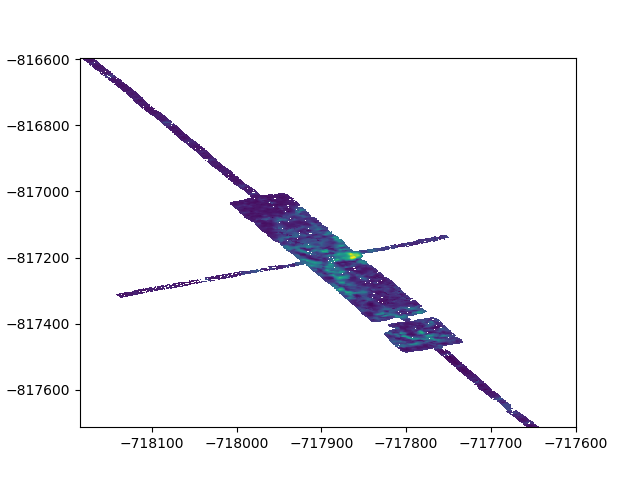

In [56]:
fig, ax = plt.subplots()

ax.pcolormesh(grid['easting'], grid['northing'], z_gridded)

In [27]:
grid_joint_x = np.concatenate((grid_deformed_x,grid_undeformed_x), axis=0)
grid_joint_y = np.concatenate((grid_deformed_y,grid_undeformed_y), axis=0)
joint_z = np.concatenate((z_deformed,z_undeformed), axis=0)

kriging_locations = np.column_stack([grid_joint_x, grid_joint_y])
validation_locations = np.column_stack([validation_subset['x'].to_list(), validation_subset['y'].to_list()])

#compare kriging results to validation datapoints
dists = cdist(validation_locations,kriging_locations)
kriging_indices = np.argmin(dists, axis=1)
point_distance = np.min(dists, axis=1)





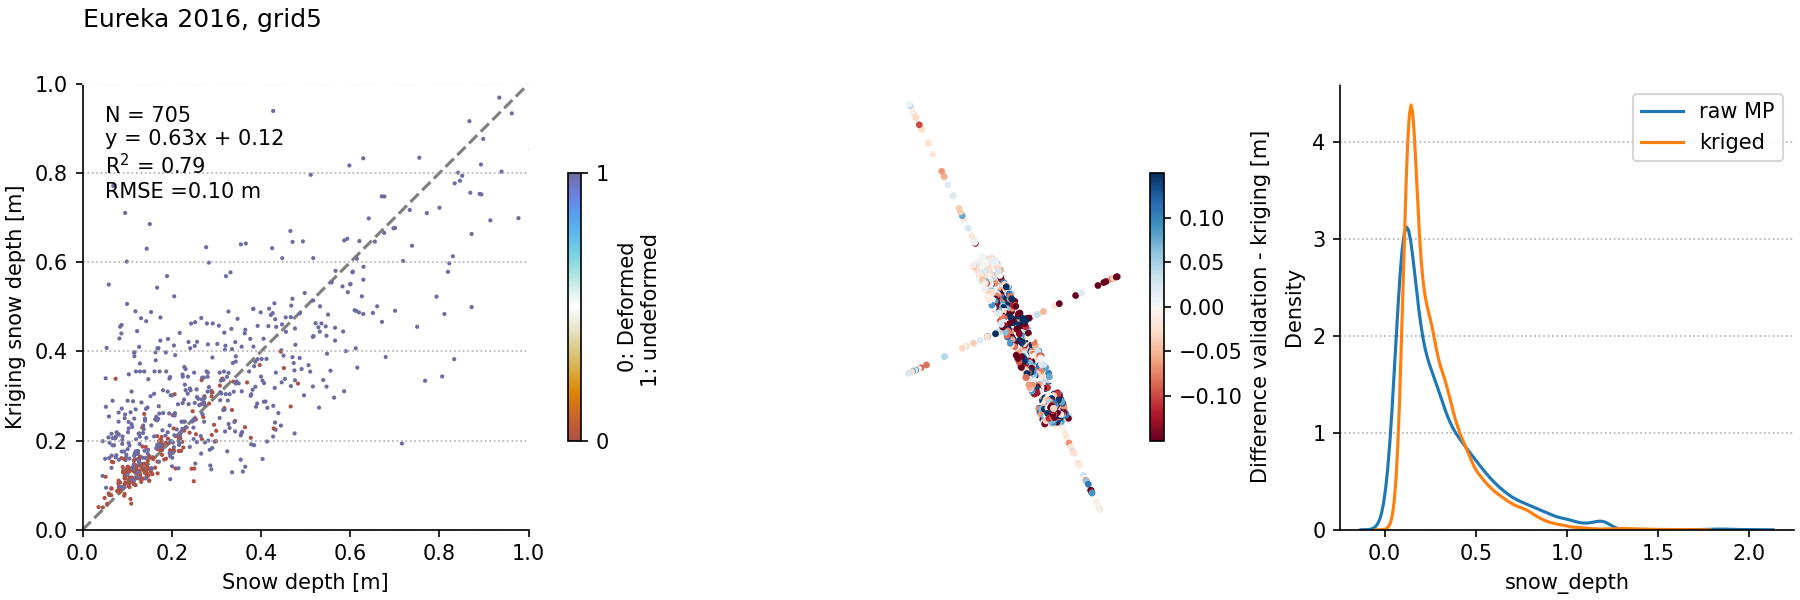

In [86]:


fig, ax = plt.subplots(1,3, figsize=(12,4), dpi=150, constrained_layout=True)
ax[0].set_aspect('equal')
ax[0].plot(np.linspace(0,1,100), np.linspace(0,1,100), zorder=0, ls='--', color='grey')

# scat = ax[0].scatter(validation_subset['snow_depth'], joint_z[kriging_indices], c=point_distance,s=1, cmap='Blues_r',vmin=0, vmax=.65)
# cbar = fig.colorbar(scat, label='Distance of datapoints [m]', shrink=.6, ax=ax[0])

scat = ax[0].scatter(validation_subset['snow_depth'], joint_z[kriging_indices], c=c[kriging_indices], s=1, cmap=cmr.prinsenvlag,vmin=0, vmax=1)
cbar = fig.colorbar(scat, label='0: Deformed\n1: undeformed ', shrink=.6, ax=ax[0])
cbar.set_ticks([0,1])

# ax.errorbar(x=validation_subset['snow_depth'], y=z_masked[kriging_indices], yerr=s2_masked[kriging_indices],ls='None', fmt='.')

linr = linregress(validation_subset['snow_depth'], joint_z[kriging_indices])
rmse = np.mean(abs(validation_subset['snow_depth']- joint_z[kriging_indices]))
ax[0].text(0.05, 0.95, f'N = {len(validation_subset)}\ny = {linr.slope:.2f}x + {linr.intercept:.2f}\nR$^2$ = {linr.rvalue:.2f}\nRMSE ={rmse:.2f} m', ha='left', va='top')
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 1)

ax[0].set_xlabel('Validation snow depth [m]')
ax[0].set_ylabel('Kriging snow depth [m]')

ax[0].set_title(f'Eureka 2016, {site}',x=0,ha='left',y =1.1)

ax[0].spines['top'].set_color('white')
ax[0].spines['right'].set_color('white')
ax[0].grid(ls=':',axis='y')


ax[1].set_aspect('equal')
ax[1].axis('off')
scat = ax[1].scatter(validation_subset['x'], validation_subset['y'],
           c=validation_subset['snow_depth'] - joint_z[kriging_indices],
           cmap='RdBu',
           norm=mcolors.TwoSlopeNorm(vmin=-.15, vcenter=0, vmax=.15),
           s=5
           )

fig.colorbar(scat, label='Difference validation - kriging [m]', shrink=.6, ax=ax[1])




sns.kdeplot(df_f['snow_depth'], label='raw MP', ax=ax[2])
sns.kdeplot(joint_z, label='kriged', ax=ax[2])

ax[2].legend()
ax[2].spines['top'].set_color('white')
ax[2].spines['right'].set_color('white')
ax[2].grid(ls=':',axis='y')
ax[0].set_xlabel('Snow depth [m]')

plt.savefig(os.path.join(plotting_path, f'{campaigns[0]}_{site}_validation.png'))

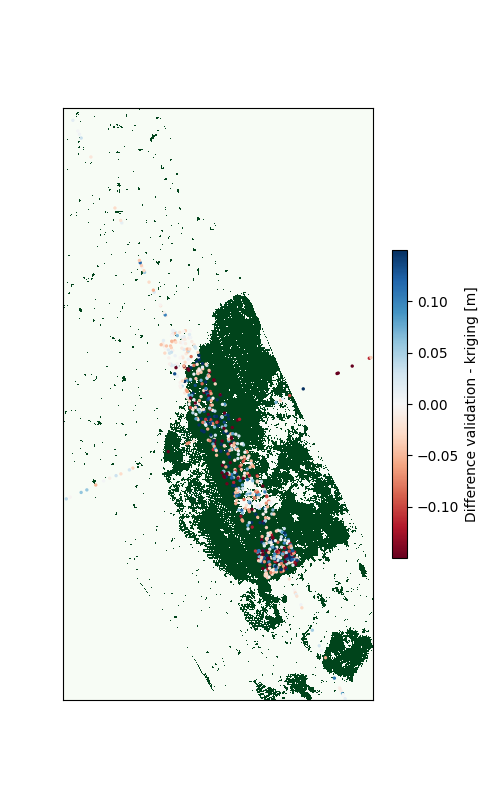

In [39]:
fig, ax = plt.subplots(figsize=(5,8))
ax.set_aspect('equal')

ax.pcolormesh(grid['easting'], grid['northing'], grid['classes'],cmap='Greens')
scat = ax.scatter(validation_subset['x'], validation_subset['y'],
           c=validation_subset['snow_depth'] - joint_z[kriging_indices],
           cmap='RdBu',
           norm=mcolors.TwoSlopeNorm(vmin=-.15, vcenter=0, vmax=.15),
           s=2
           )

fig.colorbar(scat, label='Difference validation - kriging [m]',shrink=.5)

ax.set_xticks([])
ax.set_yticks([]);


In [ ]:
df_f

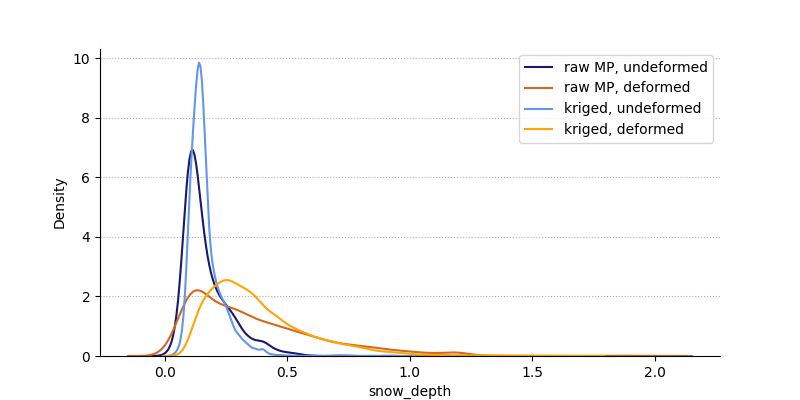

In [25]:
fig, ax = plt.subplots(figsize=(8,4))
sns.kdeplot(df_f_undeformed['snow_depth'], label='raw MP, undeformed', color='midnightblue')
sns.kdeplot(df_f_deformed['snow_depth'], label='raw MP, deformed', color='chocolate')

sns.kdeplot(z_undeformed, label='kriged, undeformed', color='cornflowerblue')
sns.kdeplot(z_deformed, label='kriged, deformed', color='orange')


# sns.kdeplot(joint_z, label='kriged')

ax.legend()
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.grid(ls=':',axis='y')